# Question Answering with BERT

Bumjin Joo

November, 2023

This Notebook contains the code used for my CS1460 Final Project! I use various HuggingFace modules and finetune pretrained models to reimplement a part of the [A BERT Baseline for the Natural Questions](https://arxiv.org/pdf/1901.08634.pdf).

The model itself is given a question and some contextual text and attempts to predict the span of text in the context which contains the answer to the question.

# Dependencies

In [ ]:
!pip install datasets==2.10.1
#load_dataset sometimes hangs on a higher version
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.9 MB/s eta 0:00:00


# Data and Preprocessing

In [ ]:
from datasets import load_dataset

import torch
import numpy as np
import random
from typing import List, Dict, Any
from tqdm import tqdm

# we set up some seeds so that we can reproduce results
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [ ]:
"""
Some options for BERT model that can be run in colab:

"distilbert-base-uncased",
"distilbert-base-uncased-distilled-squad",
"distilbert-base-cased",
"distilbert-base-cased-distilled-squad",

"""

'\nSome options for BERT model that can be run in colab:\n\n"distilbert-base-uncased",\n"distilbert-base-uncased-distilled-squad",\n"distilbert-base-cased",\n"distilbert-base-cased-distilled-squad",\n\n'

In [ ]:
# Change train.json / dev.json to the appropriate filepaths =====
from google.colab import drive
import pandas as pd
drive.mount('/content/drive', force_remount=True)

FOLDER = "/content/drive/My Drive/CS1460/final/"
# FOLDER = "./"
data_files = {"train": f"{FOLDER}/data/all_train.json", "dev": f"{FOLDER}/data/all_dev.json"}

Mounted at /content/drive


In [ ]:
def load_data(fp_dict):
  dataset = load_dataset('json', data_files=fp_dict, chunksize=10<<23)
  return dataset["train"], dataset["dev"]

In [ ]:
train_data, test_data = load_data(data_files)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-f391559dbd3cb172/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
train_data

Dataset({
    features: ['name', 'id', 'questions', 'answers', 'has_correct_context', 'contexts'],
    num_rows: 27866
})

### Preprocessing Steps
Preprocessing pipeline

In [ ]:
def preprocess_one(sample, tokenizer):

  #Get questions and context text from the samples
  #for questions, I specifically get the first string in the list, because each
  #questions list only had 1 question anyways
  sample['questions'] = list(map(lambda questions: questions[0]['input_text'], sample['questions']))
  sample['contexts'] = list(map(lambda contexts: contexts, sample['contexts']))

  #Tokenize the question and context together!
  #Outputs a Batch Encoding with [CLS] <question> [SEP] <context>
  inputs = tokenizer(
      text                    = sample['questions'],
      text_pair               = sample['contexts'],
      max_length              = 512,
      truncation              = "only_second",
      stride                  = 128,
      return_overflowing_tokens = False,
      return_offsets_mapping  = True,
      padding                 = "max_length",
      is_split_into_words     = False,
  )

  #add some relevant fields to what becomes our output
  inputs['questions'] = sample['questions']
  inputs['contexts'] = sample['contexts']

  #convert character indices to token indices!
  def batch_char_token(batch_ind, answers, has_correct):
    #if the answer to the question is known to not be in the span
    #point to the [CLS] token
    if not has_correct: return [0, 0]

    #otherwise, grab the start and end span character indices
    start = answers[0]['span_start']
    end = answers[0]['span_end']
    #and convert them to token indices
    start_token_ind = inputs.char_to_token(batch_ind, start, 1)
    end_token_ind = inputs.char_to_token(batch_ind, end-1, 1)

    #this returns None in the case that the character goes beyond the last token
    #but remember that the encoding is capped to 512
    #so if the end is out of bounds (or if the start has some weird edge case)
    #also pint to [CLS]
    if start_token_ind == None or end_token_ind == None: return [0,0]
    return [start_token_ind, end_token_ind]

  start_ends = np.array(list(map(batch_char_token, list(range(len(sample['questions']))), sample['answers'], sample['has_correct_context'])))
  inputs['start'] = start_ends[:, 0]
  inputs['end'] = start_ends[:, 1]

  #get the full [CLS] <question> [SEP] <context> input to the model
  def convert_to_string(list_tokens):
    out = ""
    for token in list_tokens: out += token + " "
    return out
  inputs['full_text'] = list(map(lambda b_ind: convert_to_string(inputs.tokens(b_ind)), range(len(sample['questions']))))

  #include the type
  inputs['has_correct_context'] = list(map(lambda has_bool: 1 if has_bool else 0, sample['has_correct_context']))

  return inputs

class QAWrapper(torch.utils.data.Dataset):
  def __init__(self, processed_dataset) -> None:
    self.base_data = processed_dataset

  def __len__(self) -> int:
    return len(self.base_data)

  def __getitem__(self, index : int) -> Dict[str, Any]:
    sample = self.base_data[index]

    #just grab what's relevant
    return {
      'questions': sample['questions'],
      'contexts': sample['contexts'],
      'full_text': sample['full_text'],
      'input_ids': torch.LongTensor(sample['input_ids']),
      'attention_mask': torch.LongTensor(sample['attention_mask']),
      'start_span': torch.tensor(sample['start']),
      'end_span': torch.tensor(sample['end']),
      'type': torch.tensor(sample['has_correct_context'])
    }

def preprocess_and_tokenize(dataset, tokenizer, dloader_args):
  from torch.utils.data import DataLoader

  #perform preprocessing steps to get a succint Dataset
  processed = train_data.map(lambda data_sample: preprocess_one(data_sample, tokenizer), batched=True)
  simplified = QAWrapper(processed)

  #and toss it into a dataloader!
  return DataLoader(simplified, **dloader_args)

In [ ]:
## MAKE SURE TO RUN GET MODEL FIRST!!
q_proc = train_data.map(lambda samp: preprocess_one(samp, tokenizer), batched=True)
simplified = QAWrapper(q_proc)

ex = simplified[0]
print(f"keys: {ex.keys()}")
print(f"question: {ex['questions']}")
print(f"context: {ex['contexts']}")
print(f"model input: {ex['full_text']}")
print(f"answer: {ex['full_text'].split(' ')[ex['start_span']:ex['end_span']+1]}")

Map:   0%|          | 0/27866 [00:00<?, ? examples/s]

keys: dict_keys(['questions', 'contexts', 'full_text', 'input_ids', 'attention_mask', 'start_span', 'end_span', 'type'])
question: when does stephanie die in grey's anatomy
context: Dr. Stephanie Edwards Grey 's Anatomy character The Season 12 Promotional Photo of Jerrika Hinton as Stephanie Edwards First appearance Going , Going , Gone ( 9.01 ) September 27 , 2012 ( as recurring cast ) `` Seal Our Fate '' ( 10.01 ) September 26 , 2013 ( as series regular ) Last appearance `` Ring of Fire '' ( 13.24 ) May 18 , 2017 Created by Shonda Rhimes Portrayed by Jerrika Hinton Information Full name Stephanie Edwards Nickname ( s ) Grumpy Steph Dr. Lavender Title M.D. Significant other ( s ) Jackson Avery Kyle Diaz ( deceased )
model input: [CLS] when does step ##hani ##e die in grey ' s anatomy [SEP] Dr . Stephanie Edwards Grey ' s Anatomy character The Season 12 Promotion ##al Photo of Je ##rri ##ka Hi ##nton as Stephanie Edwards First appearance Going , Going , Gone ( 9 . 01 ) September 27 , 2

# Model Building

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

import gc
def free_mem():
  if device == "cuda": torch.cuda.empty_cache()
  gc.collect()

## Model Wrapper
Consists of the model, call function, and loss function in a convenient package!

In [ ]:
class QAModel():
  """
  Wrapper Class for a Question Answering Model
  Becomes useful when we need to add extra output heads!
  More of a Tensorflow-y way of doing it though
  """
  def __init__(self, model, model_is_qa = True):
    """
    Parameters:
    -----------
    model : torch.nn.Module
        The HuggingFace DistilBert model
    model_is_qa : boolean
        This should be True if model is a ForQuestionAnsweringModel
        (i.e. it already has the QuestionAnswering classifier heads)
        and false otherwise... Not implemented for False though!!
    """

    self.model = model
    self.softmax = torch.nn.Softmax(dim = 1)
    self.optimizer = None

    ### If we're not using the prebaked QuestionAnswering model
    ### We can add on extra prediction heads to be called in call for different
    ### predictions, like a type prediction.
    # if not model_is_qa:
    #   self.predition_head = ...

  def call(self, input_ids, attention_mask):
    """
    Parameters:
    -----------
    input_ids
        The tokenized model inputs (batched)
    attention_mask :
        The attention mask from the tokenizer for the batch of inputs

    Returns:
    -----------
    The model's predictions for start and end tokens. Specifically returns
    a probability distribution across all input tokens for starting and ending
    tokens (what does the model think is the probability that this token is the
    start/end of the answer span?).
    """
    model_preds = self.model(input_ids = input_ids, attention_mask = attention_mask)
    start_logits, end_logits = model_preds['start_logits'], model_preds['end_logits']
    start_probs, end_probs = self.softmax(start_logits), self.softmax(end_logits)
    return start_probs, end_probs

  def parameters(self):
    """
    Returns:
    -----------
    The model's parameters
    """
    return self.model.parameters()

  def train(self):
    """
    Puts the model into train mode
    """
    self.model.train()

  def eval(self):
    """
    Puts the model into eval mode
    """
    self.model.eval()

  def loss(self, start_probs, start_span, end_probs, end_span):
    """
    Parameters:
    -----------
    start_probs: the probability distribution across tokens being the starts of
                  the answer spans
    start_span: the true starts of the answer spans
    end_probs: the probability distribution across tokens being the ends of
                  the answer spans
    end_span: the true ends of the answer spans

    Returns:
    -----------
    Calculates loss on predictions. Loss is the negative log of the probability
    assigned to the ground truth start/end answer span token.
    Returns an average across all samples in the batch
    """
    def token_loss(probs, labels):
      prob_of_correct = probs.gather(1, labels.view(-1, 1))
      return -torch.log(prob_of_correct)

    # take average of per-sample loss in batch
    start_loss = token_loss(start_probs, start_span)
    end_loss = token_loss(end_probs, end_span)

    loss_tensor = start_loss + end_loss
    return torch.mean(loss_tensor)

  def save(self, epoch_num, loop, loss_dict):
    """
    Saves model to My Drive
    """
    file_path = f"{FOLDER}/checkpoints/qa_model_e{epoch_num}_{loop}.pt"
    torch.save({'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                **loss_dict,
    }, file_path)

  def load(self, epoch_num, loop):
    """
    Loads model from My Drive
    """
    file_path = f"{FOLDER}/checkpoints/qa_model_e{epoch_num}_{loop}.pt"
    if loop == "train":
      keys = ['batch_loss', 'train_loss']
    else:
      keys = ['valid_loss']

    checkpoint = torch.load(file_path)
    self.model.load_state_dict(checkpoint['model_state_dict'])
    self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss_dict = {}
    for key in keys: loss_dict[key] = checkpoint[key]


## Loss Function

Definition From Paper:
$$
\begin{align}
L &= − \log p(s, e, t|c)\\
&= − \log p_\text{start}(s|c) \\
&\;\;\;− \log p_\text{end}(e|c)\\
&\;\;\;− log p_\text{type}(t|c),
\end{align}
$$

Where:
$$
p_\text{start}(s|c) = \frac{\exp(f_\text{start}(s, c; \theta))}{\sum_{s'}\exp(f_\text{start}(s', c; \theta)}\\
p_\text{end}(e|c) = \frac{\exp(f_\text{end}(e, c; \theta))}{\sum_{s'}\exp(f_\text{end}(e', c; \theta)}\\
p_\text{type}(t|c) = \frac{\exp(f_\text{type}(t, c; \theta))}{\sum_{s'}\exp(f_\text{type}(t', c; \theta)}\\
$$



## Getting The Model

In [ ]:
def load_model(device, model_type = "distilbert-base-uncased", get_qa = True):
  ### Taken from A4!
  from transformers import AutoConfig, AutoTokenizer, AutoModel, AutoModelForQuestionAnswering

  if get_qa:
    model_type = "distilbert-base-cased-distilled-squad"
    qa_model = AutoModelForQuestionAnswering.from_pretrained(model_type).to(device)
    model = QAModel(qa_model, model_is_qa = get_qa)
    tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
    return model, tokenizer

  # config = AutoConfig.from_pretrained(model_type)
  # model = AutoModel.from_config(config)
  # model = model.to(device)

  # tokenizer = AutoTokenizer.from_pretrained(model_type)

  # return model, tokenizer

In [ ]:
model, tokenizer = load_model(device, get_qa = True)
model

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
model.model

DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
      

# DataLoaders
Instantiating the Data Loaders

In [ ]:
dloader_args = {"batch_size": 16, "shuffle": True}
train_data_loader = preprocess_and_tokenize(train_data, tokenizer, dloader_args = dloader_args)
validation_data_loader = preprocess_and_tokenize(test_data, tokenizer, dloader_args = dloader_args)

tensor_fields = ['input_ids', 'attention_mask','correct_context','start_span','end_span']

# HyperParams

In [ ]:
# Using Hyper Parameters from HW4
from transformers import get_scheduler

num_epochs = 1

model.optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

lr_scheduler = get_scheduler(
  "linear",
  optimizer=model.optimizer,
  num_warmup_steps=50,
  num_training_steps=1742 * num_epochs
)

# Training

In [ ]:
tensor_fields = ['input_ids', 'attention_mask','correct_context','start_span','end_span']

def train_step(model, dataloader, lr_scheduler, device, is_testing=False) -> list:
  """
  Runs a single step in training. Predicts on all batches in the dataloader

  Parameters:
  -----------
  model : torch.nn.Module
      The model to be trained.
  dataloader : DataLoader
      DataLoader containing examples.
  lr_scheduler : Any
      Learning rate scheduler.
  device : torch.device
      The device that the training will be performed on.
  is_testing : boolean
      Whether or not we are training the model

  Returns:
  --------
  step_losses:
      The losses, per batch, of the last training epoch. Used later for
      visualizing training performance
  """
  if is_testing: model.eval()
  else: model.train()

  step_losses = []

  for batch in tqdm(dataloader):
    #move everything to device
    for key in batch:
      if key in tensor_fields: batch[key] = batch[key].to(device)

    free_mem() #clear unreferenced data

    #preds and loss
    start_probs, end_probs = model.call(input_ids = batch['input_ids'], attention_mask = batch['attention_mask'])
    loss = model.loss(start_probs, batch['start_span'], end_probs, batch['end_span'])
    if not is_testing:
      loss.backward()
      model.optimizer.step()
      lr_scheduler.step()
      model.optimizer.zero_grad()

    step_losses.append(loss.item())
    del loss
    free_mem()

  del batch
  free_mem()
  return step_losses

In [ ]:
tensor_fields = ['input_ids', 'attention_mask','correct_context','start_span','end_span']

def train(model, num_epochs, train_dataloader, val_dataloader, lr_scheduler, device):
  """
  Trains a model by performing a forward pass and backpropating on batches to optimize loss.

  Parameters:
  -----------
  model : torch.nn.Module
      The model to be trained.
  num_epochs : int
      Number of epochs to train for.
  train_dataloader : DataLoader
      DataLoader containing training examples.
  validation_dataloader : DataLoader
      DataLoader containing validation examples.
  lr_scheduler : Any
      Learning rate scheduler.
  device : torch.device
      The device that the training will be performed on.

  Returns:
  --------
  train_epoch_losses:
      The losses, per batch, of the last training epoch. Used later for
      visualizing training performance

  avg_train_losses:
      The average training losses, per epoch
  avg_val_losses:
      The average validation losses, per epoch
  """

  avg_train_losses = []
  avg_val_losses = []

  for epoch in range(num_epochs):
    model.train()

    print(f"Epoch {epoch + 1} training:")
    model.optimizer.zero_grad()

    train_epoch_losses = train_step(model, train_dataloader, lr_scheduler, device)
    avg_train_losses.append(torch.mean(torch.tensor(train_epoch_losses)))

    free_mem()

    val_epoch_losses = train_step(model, val_dataloader, lr_scheduler, device, is_testing=True)
    avg_val_losses.append(torch.mean(torch.tensor(val_epoch_losses)))
    del val_epoch_losses

    free_mem()

  return train_epoch_losses, avg_train_losses, avg_val_losses

# Evaluation

In [ ]:
def pred_stats(labels, preds):
  """
  Calculate base metrics on predicted spans

  Parameters:
  -----------
  labels:
      The ground truth span of token (ids) which answer the question
  preds:
      The predicted (most likely) span of token ids which (theoretically)
      answer the question

  Returns:
  --------
  tp: True Positives
      Defined as tokens which appear in both the ground truth and predicted spans
      If a token occur multiple times, the minimum number of occurrences between
      the two spans is taken
  fp: False Positives
      Defined as tokens which appear in the predicted spans but not the ground
      truth span.
  fn: False Negatives
      Defined as tokens which appear in the ground truth span, but not the
      predicted span.
  """

  from collections import Counter
  #get tp, fp, fn
  label_counts = Counter(labels)
  pred_counts = Counter(preds)
  tp = 0
  fp = 0
  fn = 0
  for pred_token in pred_counts:
    tp += min(pred_counts[pred_token], label_counts[pred_token])
    if label_counts[pred_token] == 0: fp += pred_counts[pred_token]

  for label_token in label_counts:
    if pred_counts[label_token] == 0: fn += label_counts[label_token]

  return tp, fp, fn

def evaluate(model, test_dataloader, device):
  """
  Evaluate a PyTorch Model

  Parameters:
  -----------
  model : torch.nn.Module
      The model to be evaluated.
  test_dataloader : torch.utils.data.DataLoader
      DataLoader containing testing examples.
  device : torch.device
      The device that the evaluation will be performed on.

  Returns:
  --------
  The average (per-sample) precision, recall, and f1 scores.
  """
  # load metrics
  model.eval()

  precisions, recalls, f1s = 0,0,0

  num_batches = 0
  max_batches = 300

  for test_batch in tqdm(test_dataloader):
    # print(f"\nTest Batch {test_batch['full_text'][0]}")
    for key in test_batch:
      if key in tensor_fields: test_batch[key] = test_batch[key].to(device)

    free_mem()

    start_probs, end_probs = model.call(input_ids = test_batch['input_ids'], attention_mask = test_batch['attention_mask'])
    start_pred, end_pred = torch.argmax(start_probs, dim = 1), torch.argmax(end_probs, dim = 1)

    for ind in range(len(test_batch['start_span'])):
      sample = test_batch['full_text'][ind].split(" ")
      start = test_batch['start_span'][ind]
      end = test_batch['end_span'][ind]
      pred_start = start_pred[ind]
      pred_end = end_pred[ind]

      # print(f"Sample: {sample}")
      # print(f"Start: {start}")
      # print(f"End: {end}")
      # print(f"Predicted Start: {pred_start}")
      # print(f"Predicted End: {pred_end}")

      label_tokens = sample[start:end+1]
      pred_tokens = sample[pred_start:pred_end+1]

      # print(f"Label Span: {label_tokens}\nPredicted Span: {pred_tokens}")
      tp, fp, fn = pred_stats(label_tokens, pred_tokens)

      if len(label_tokens) == 0: p = 0
      else: p = float(tp)/float(len(label_tokens))

      if tp + fn == 0: r = 0
      else: r = float(tp)/float(tp + fn)

      # print(f"Precision: {p}, Recall: {r}")
      precisions += p
      recalls += r

      if p+r == 0: f1s += 0
      else: f1s += (2.0 * (p * r) / (p + r))

      del label_tokens, pred_tokens
      free_mem()
    num_batches += 1
    if num_batches > max_batches: break

  return precisions / (max_batches * 16), recalls / (max_batches * 16), f1s / (max_batches * 16)

# Running My Code
Because my Notebooks would persistently run out of VRAM, I separate every training step and save weights in the middle so I can reset my notebook between each one.

## Epoch 1

### Training

In [ ]:
epoch = 1
dloader_args = {"batch_size": 16, "shuffle": True}
train_data_loader = preprocess_and_tokenize(train_data, tokenizer, dloader_args = dloader_args)

batch_losses = train_step(model, train_data_loader, lr_scheduler, device)
epoch_loss = torch.mean(torch.tensor(batch_losses))
loss_dict = {'batch_loss': batch_losses, 'train_loss': epoch_loss}
model.save(epoch, "train", loss_dict)

Map:   0%|          | 0/27866 [00:00<?, ? examples/s]

100%|██████████| 1742/1742 [33:30<00:00,  1.15s/it]


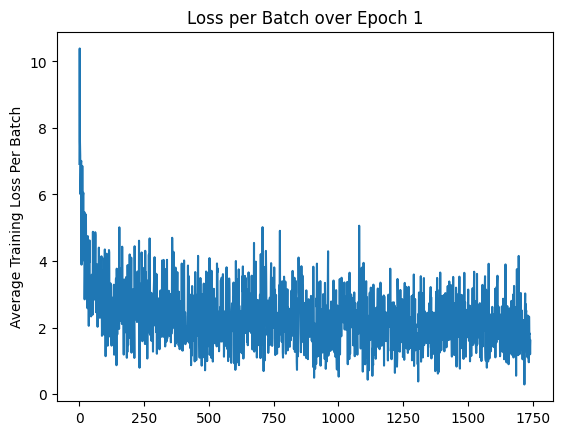

Average Epoch 1 Training Loss: 2.3253347873687744


In [ ]:
import matplotlib.pyplot as plt

plt.plot(torch.tensor(batch_losses).cpu())
plt.ylabel('Average Training Loss Per Batch')
plt.title(f'Loss per Batch over Epoch {epoch}')
plt.show()

print(f"Average Epoch {epoch} Training Loss: {epoch_loss}")

### Validation

In [ ]:
epoch = 1
model.load(epoch, "train")

dloader_args = {"batch_size": 16, "shuffle": True}
validation_data_loader = preprocess_and_tokenize(test_data, tokenizer, dloader_args = dloader_args)

batch_losses = train_step(model, validation_data_loader, lr_scheduler, device, is_testing=True)
epoch_loss = torch.mean(torch.tensor(batch_losses))
print(f"Average Epoch {epoch} Validation Loss: {epoch_loss}")

Map:   0%|          | 0/27866 [00:00<?, ? examples/s]

100%|██████████| 1742/1742 [22:03<00:00,  1.32it/s]


Average Epoch 1 Validation Loss: 1.3887593746185303


In [ ]:
epoch = 1
model.load(epoch, "train")

dloader_args = {"batch_size": 16, "shuffle": True}
validation_data_loader = preprocess_and_tokenize(test_data, tokenizer, dloader_args = dloader_args)

precision, recall, f1_score  = evaluate(model, validation_data_loader, device)

print("\nEvaluating on first 100 validation batches")
print("PRECISION: ", precision)
print("RECALL: ", recall)
print("F1-SCORE: ", f1_score)

  6%|▌         | 100/1742 [04:47<1:18:32,  2.87s/it]


Evaluating on first 100 validation batches
PRECISION:  0.8408296582149691
RECALL:  0.8419724506165764
F1-SCORE:  0.8412814389879537


## Epoch 2

### Training

In [ ]:
epoch = 1
model.load(epoch, "train")
epoch += 1

dloader_args = {"batch_size": 16, "shuffle": True}
train_data_loader = preprocess_and_tokenize(train_data, tokenizer, dloader_args = dloader_args)

batch_losses = train_step(model, train_data_loader, lr_scheduler, device)
epoch_loss = torch.mean(torch.tensor(batch_losses))
loss_dict = {'batch_loss': batch_losses, 'train_loss': epoch_loss}
model.save(epoch, "train", loss_dict)

Map:   0%|          | 0/27866 [00:00<?, ? examples/s]

100%|██████████| 1742/1742 [35:08<00:00,  1.21s/it]


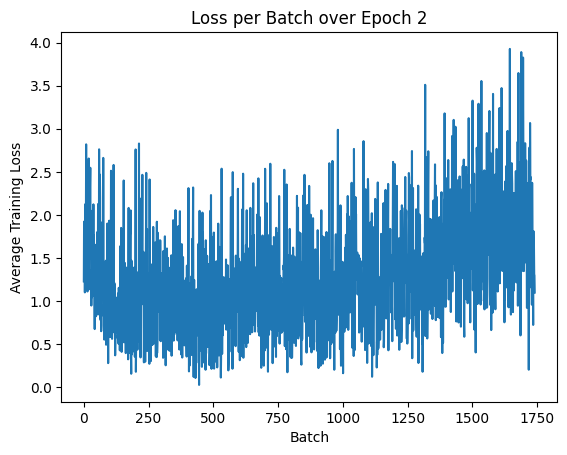

Average Epoch 2 Loss: 1.282586932182312


In [ ]:
import matplotlib.pyplot as plt

plt.plot(torch.tensor(batch_losses).cpu())
plt.ylabel('Average Training Loss')
plt.xlabel('Batch')
plt.title(f'Loss per Batch over Epoch {epoch}')
plt.show()

print(f"Average Epoch {epoch} Loss: {epoch_loss}")

### Validation

In [ ]:
epoch = 2
model.load(epoch, "train")

dloader_args = {"batch_size": 16, "shuffle": True}
validation_data_loader = preprocess_and_tokenize(test_data, tokenizer, dloader_args = dloader_args)


batch_losses = train_step(model, validation_data_loader, lr_scheduler, device, is_testing=True)
epoch_loss = torch.mean(torch.tensor(batch_losses))
loss_dict = {'valid_loss': epoch_loss}
model.save(epoch, "valid", loss_dict)

Map:   0%|          | 0/27866 [00:00<?, ? examples/s]

100%|██████████| 1742/1742 [20:32<00:00,  1.41it/s]


In [ ]:
print(f"Average Epoch {epoch} Validation Loss: {epoch_loss}")

Average Epoch 2 Validation Loss: 0.9641684293746948


In [ ]:
epoch = 2
# model.load(epoch, "train")

dloader_args = {"batch_size": 16, "shuffle": True}
validation_data_loader = preprocess_and_tokenize(test_data, tokenizer, dloader_args = dloader_args)

precision, recall, f1_score  = evaluate(model, validation_data_loader, device)

print("\nEvaluating on first 300 validation batches")
print("PRECISION: ", precision)
print("RECALL: ", recall)
print("F1-SCORE: ", f1_score)

 17%|█▋        | 300/1742 [15:05<1:12:33,  3.02s/it]


Evaluating on first 300 validation batches
PRECISION:  0.8937524581092542
RECALL:  0.8949241066824832
F1-SCORE:  0.8942348265150047


# Main Function
Due to memory constraints, I really couldn't run the main function. However, Looking above, I do have all of my outputs stored. My approach was to download the weights to My Drive and reset the Runtime after every train / validation step. I'm not really sure why my memory clearing didn't work, but after my train step my memory usage would drop to 1.4GB before jumping back up to 14.5GB and giving me a CUDA Out of Memory Error.

Perhaps you might have better luck on better hardware?

In [ ]:
def main():
  '''Here's the basic structure of the main block -- feel free to add or
  remove parameters/helper functions as you see fit, but all steps here are
  needed and we expect to see precision, recall, and f1 scores printed out'''
  device = "cuda" if torch.cuda.is_available() else "cpu"
  batch_size = 64

  model, tokenizer = load_model(device = device)
  train, validation = load_data(fp_dict = data_files)

  dloader_args = {"batch_size": batch_size, "shuffle": True}

  train_data_loader = preprocess_and_tokenize(train, tokenizer, dloader_args = dloader_args)
  validation_data_loader = preprocess_and_tokenize(validation,  tokenizer, dloader_args = dloader_args)

  train_epoch_losses, train_losses, val_losses = train(model, num_epochs, train_data_loader, validation_data_loader, lr_scheduler, device)
  precision, recall, f1_score  = evaluate(model, validation_data_loader, device)

  print("PRECISION: ", precision)
  print("RECALL: ", recall)
  print("F1-SCORE: ", f1_score)

if __name__ == "__main__":
  main()